## **Data Description**

*     client_id - client's id number

*     education - level of education
 
*     sex - client's sex
 
*     age - client's age
 
*     car - car presence
 
*     car_type - foreign car or not
 
*     decline_app_cnt - number of previous credit refusals
 
*     good_work - "good" job presence
 
*     bki_request_cnt - number of loan requests to Credit Bureau
 
*     home_address - category of home address
 
*     work_address - category of work address
 
*     income - client's income
 
*     foreign_passport - foreign passport presence
 
*     default - default presence (i.e. failure to fulfil an obligation/to repay a loan)
 
*     app_date - application date
 
*     first_time - how long the bank has info about this client
 
*     sna - relation to bank's clients
 
*     region_rating - client's region rating

# Import of modules

In [4]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler


from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Setting default graph parameters
sns.set(style='whitegrid')
sns.set(style='whitegrid')
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['axes.labelsize'] = 15

Fixing Random seed and package version for reproducible experiments:

In [5]:
RANDOM_SEED = 42

!pip freeze > requirements.txt

Uploading datasets

In [6]:
test = pd.read_csv('/Users/andrei/Desktop/SkillFactory/Project 5 Компьютер говорит нет/test.csv')
train = pd.read_csv('/Users/andrei/Desktop/SkillFactory/Project 5 Компьютер говорит нет/train.csv')
sample_sub = pd.read_csv('/Users/andrei/Desktop/SkillFactory/Project 5 Компьютер говорит нет/sample_submission.csv')

For correct preprocecing, features train and test combining into one dataset 

In [7]:
train['sample'] = 1 # signing as train
test['sample'] = 0  # singning as test 
test['default'] = 0 # in the test there is no default, it's a target feature, therefore fulling it with zeros
# Using concat fanction to combine dataframes
df1 = pd.concat([train, test], axis=0, ignore_index=True)

Looking for the duplicate rowas in the dataset

In [8]:
print('No duplicates found' if df1.duplicated().sum() == 0 else 'Duplicates found')

No duplicates found


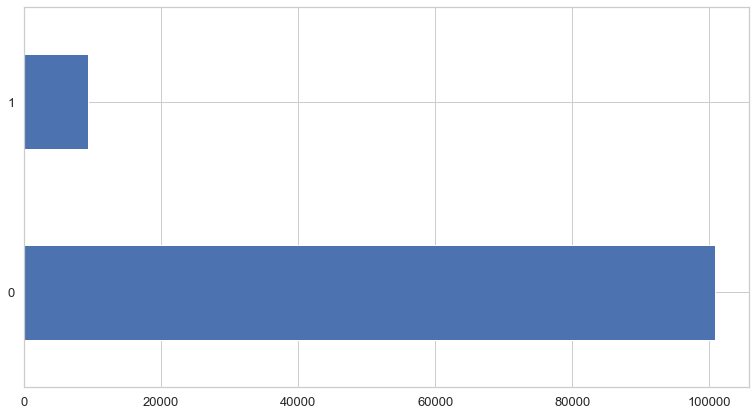

In [9]:
df1.default.value_counts().plot.barh()
None

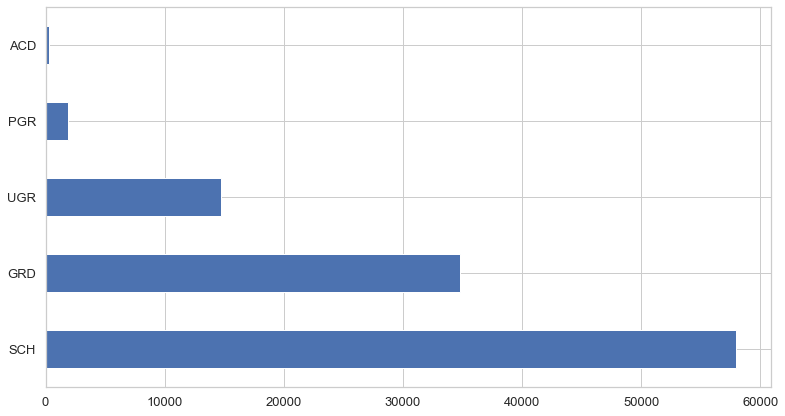

In [10]:
df1.education.value_counts().plot.barh()
None

Creating a feature "season" out of feature "app_date"

In [11]:
df1['app_date'] = pd.to_datetime(df1['app_date'])
df1['month'] = df1['app_date'].dt.month
df1['season'] = df1['app_date'].dt.month
df1['season'] = [(month%12 + 3)//3 for month in df1['season']]
df1['season'] = df1['season'].astype('object')
df1['month'] = df1['month'].astype('object')

In [12]:
df1.season.value_counts()

2    57863
1    52285
Name: season, dtype: int64

We've got only two season in out dataset where 1 stands for 'winter' and 2 stands for 'spring'

Utilizing KNN Imputer to predict missing values in education feature

In [14]:
# Dropping an unnecessary column
df1.drop(['client_id'], axis=1, inplace=True)

# Due-to inconvinience of work with missing values using LableEncoder, first of all data should be pre-preocessed
# Filling missing values in education with 'missing'
df1.education = df1.education.fillna('missing')

# Encoding feature education
label_encoder = LabelEncoder()
df1.education = pd.Series(label_encoder.fit_transform(df1['education']))

# Swapping up encoded values, {5: 'missing'} back to NaN
df1.education = df1.education.replace(5, np.nan)

# Preparing KNNImputer,fitting and transforming data 
imputer = KNNImputer(n_neighbors=5, weights='distance')
df1.education = imputer.fit_transform((df1.education.values).reshape(-1, 1))

Dropping unneccerery columns

In [15]:
df1 = df1.drop(['app_date'], axis=1)

Dividing features by its type for future processing

In [16]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

cat_cols = ['education', 'home_address', 'work_address', 'first_time', 'sna', 'season', 'month'] 

num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']

target = 'default'

Encoding all features to a numeric type

In [17]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df1[column] = label_encoder.fit_transform(df1[column])
    # Checking if the encoding was performed correctly
    print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 0, 1: 1}
{0: 'N', 1: 'Y'}


# Categorical features

**Gender destribution**

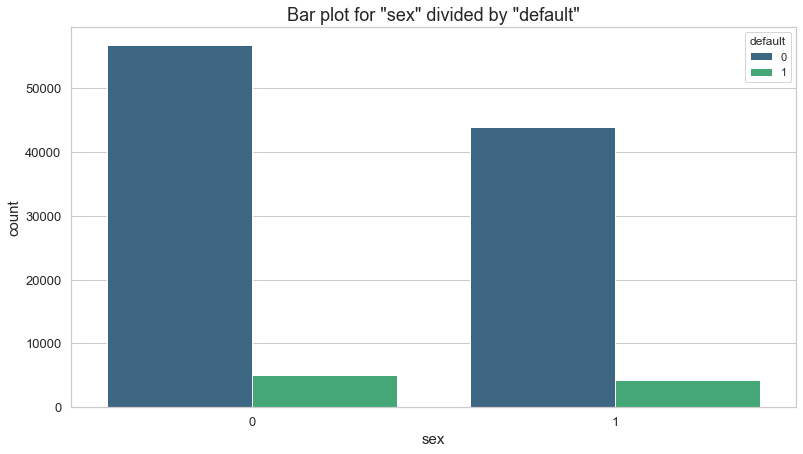

In [18]:
sns.countplot(df1.sex, hue=df1.default, palette='viridis')
plt.title('Bar plot for "sex" divided by "default"', size=18);

In the observation it is seen, that there are more men tham wemen, as well as proportion of defaulted people between men and wemen looks similar

**Car preferences**

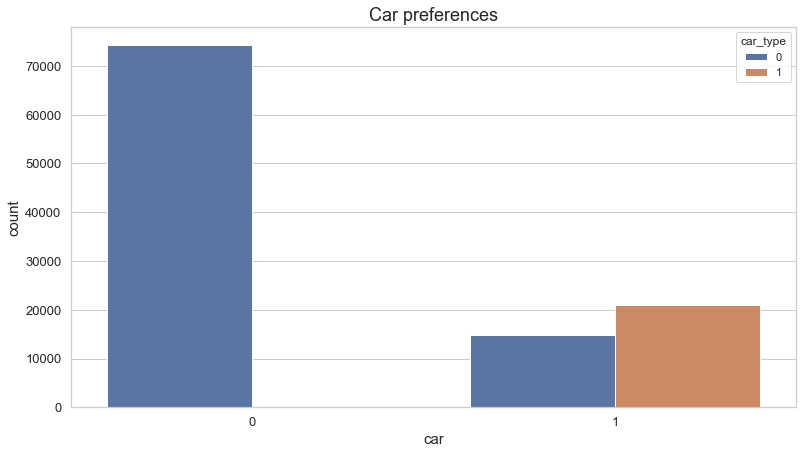

In [19]:
sns.countplot(df1.car, hue=df1.car_type)
plt.title('Car preferences', size=18);

It is seen that among those who have a car, stands out preference of foreign cars

**Distribution of type of work**

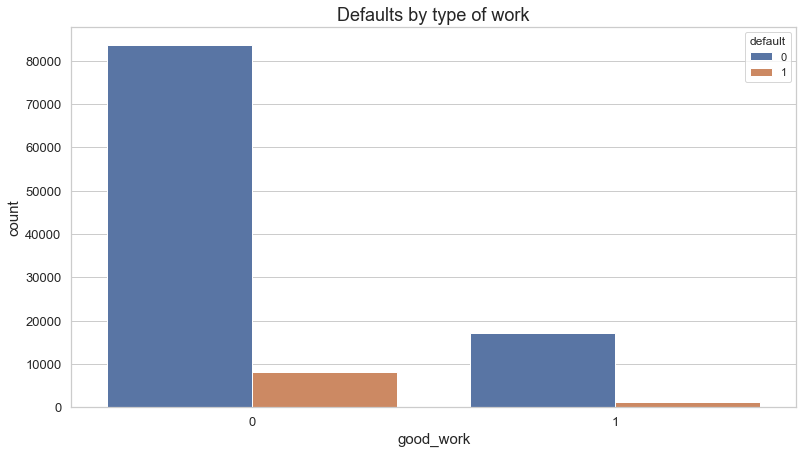

In [21]:
sns.countplot(df1.good_work, hue=df1.default)
plt.title('Defaults by type of work', size=18);

People in the dataset with good work more likely have less defaults

**Home address**

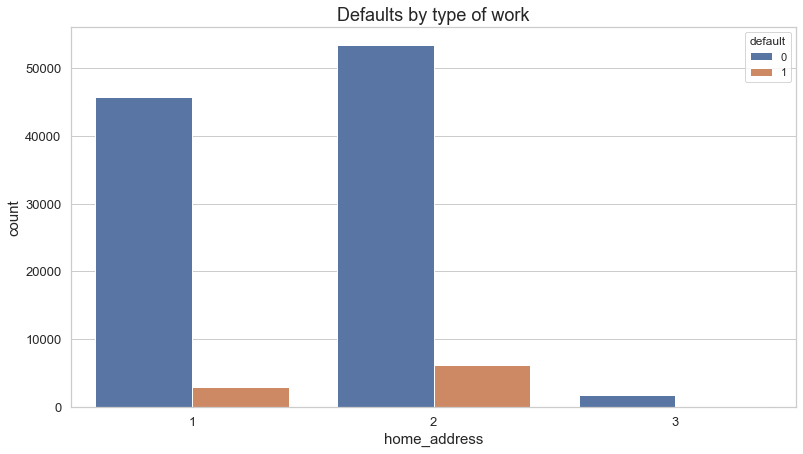

In [23]:
sns.countplot(df1.home_address, hue=df1.default)
plt.title('Defaults by type of work', size=18);

The minority of people with 3th type of address almost did not have a default. However this gruop is to small to consider in as a good reference. 

**Work address**

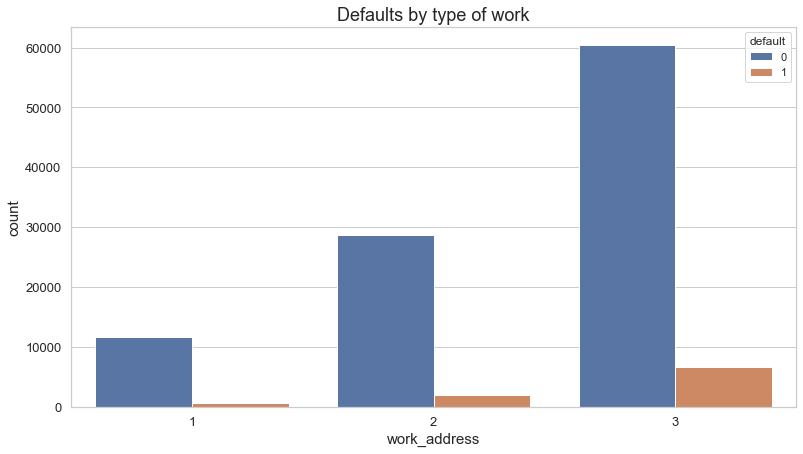

In [24]:
sns.countplot(df1.work_address, hue=df1.default)
plt.title('Defaults by type of work', size=18);

The minority of people with 1st type of work had less defaults in comparison with others

Destribution of SNA column

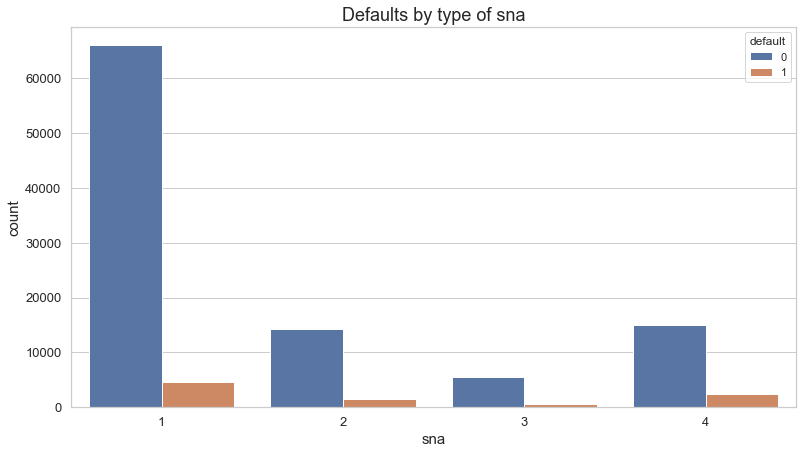

In [26]:
sns.countplot(df1.sna, hue=df1.default)
plt.title('Defaults by type of sna', size=18)
None

The distribution of people number by different type of sna is uneven, and defaults are present in each type of sna.

**Distribution of first time column**

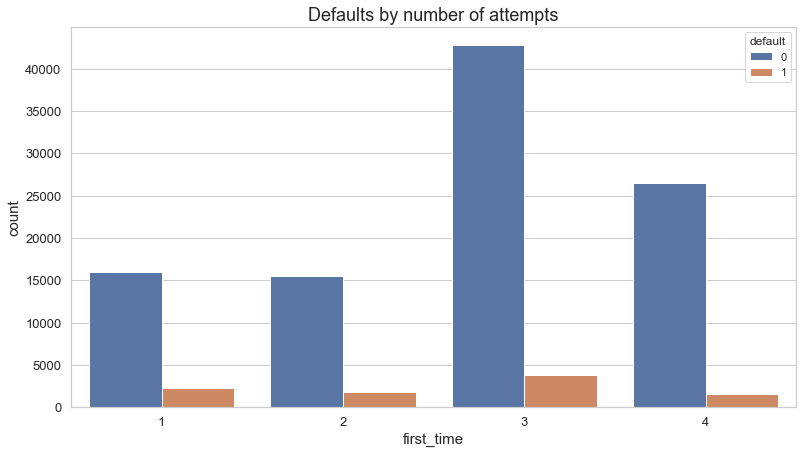

In [27]:
sns.countplot(df1.first_time, hue=df1.default)
plt.title('Defaults by number of attempts', size=18);

Most of the people have been clients of the bank for a long time

# Numeric features

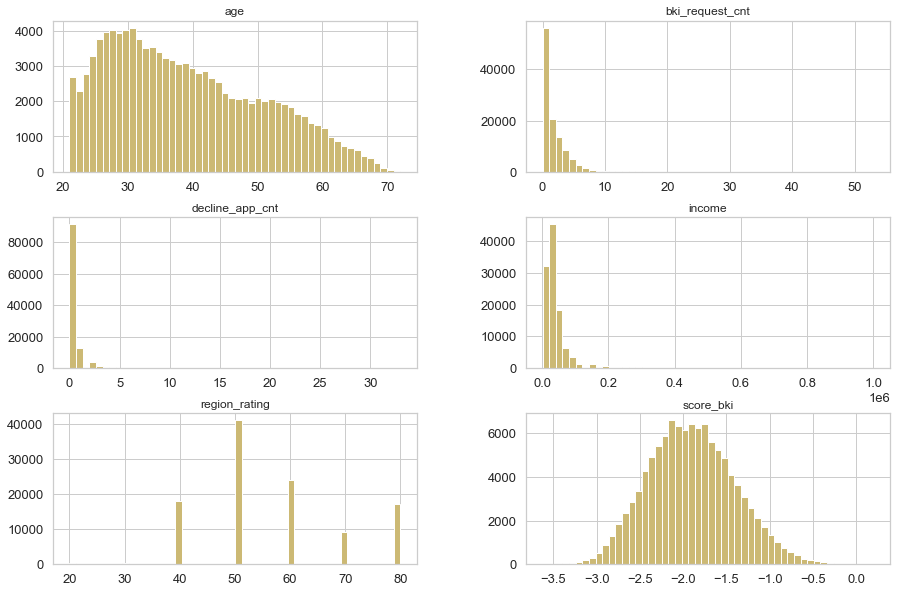

In [28]:
df1[num_cols].hist(bins=50, figsize=(15, 10), color='y');

Some features does not have shape of normal distribution, therefore for better model performance advised to logarithm these features

To deal with the skewness, applying logorithmic transformation to some of the feature

In [29]:
log_cols = ['income', 'age', 'decline_app_cnt', 'bki_request_cnt']

for column in log_cols:
    df1[column] = [np.log(x + 1) for x in df1[column]]

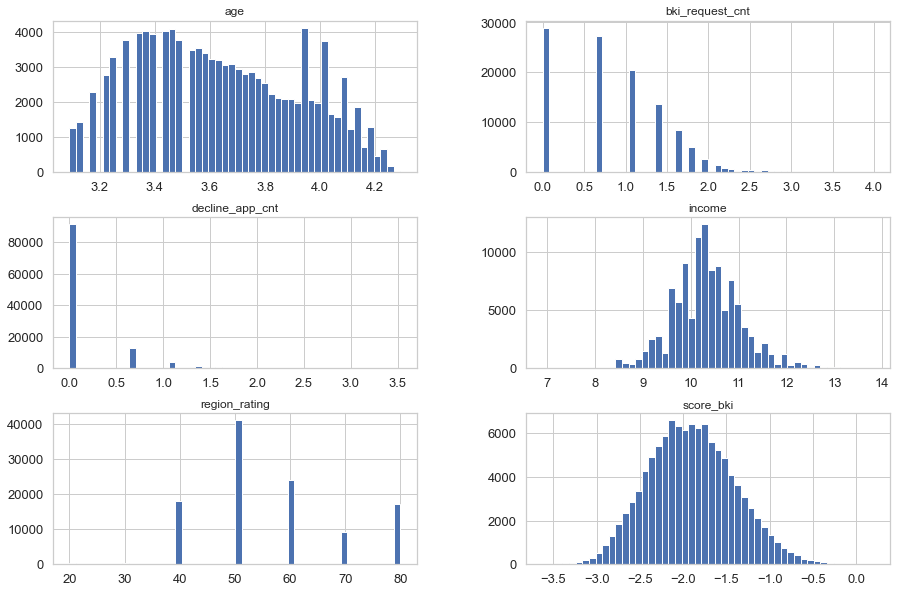

In [30]:
df1[num_cols].hist(bins=50, figsize=(15, 10), color='b');

After logorifmic transformation some of the features have gotten distribution closer to normal shape

Checking out for outliers

In [31]:
def outliers(data, column):
    perc25, perc75 = np.percentile(df1[column], [25, 75])
    iqr = perc75 - perc25
    lower_bound = perc25 - (iqr * 1.5)
    upper_bound = perc75 + (iqr * 1.5)
    return np.where((df1[column] > upper_bound) | (df1[column] < lower_bound))[0]

In [32]:
for col in num_cols:
    outliers_count = outliers(df1, col)
    print(f'{len(outliers_count)} outliers are founs in column "{col}"')

0 outliers are founs in column "age"
18677 outliers are founs in column "decline_app_cnt"
15 outliers are founs in column "bki_request_cnt"
2609 outliers are founs in column "income"
518 outliers are founs in column "score_bki"
17917 outliers are founs in column "region_rating"


# Correlation Analysis

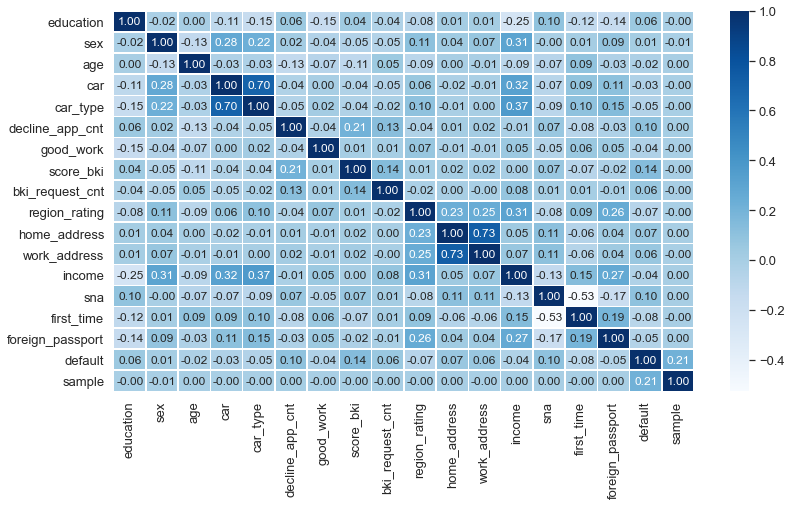

In [33]:
corr = df1.corr()
sns.heatmap(corr, annot=True, fmt='.2f', linewidth=.5, cmap='Blues');

In [ ]:
poly = PolynomialFeatures(2)
        X_test = poly.fit_transform(X_train)
        X_test = poly.fit_transform(X_test)

# Inspecting significance of numerical and binary features
Conduction of ANOVA

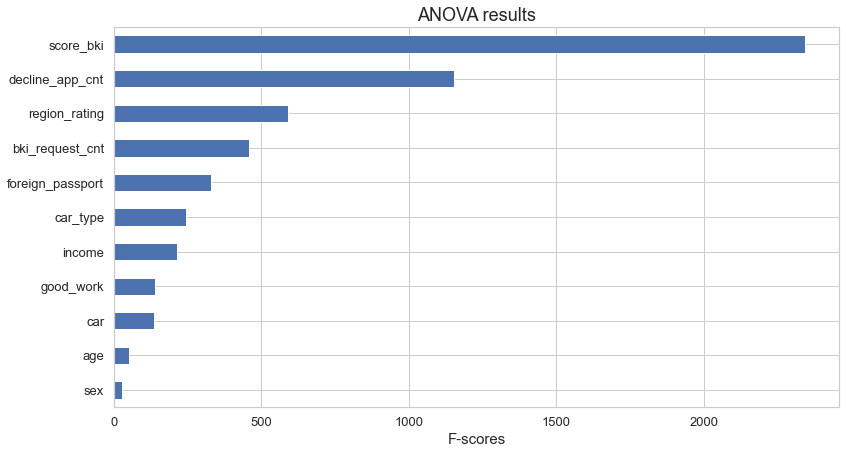

In [34]:
imp_num = pd.Series(f_classif(df1[df1['sample']==1][bin_cols + num_cols], 
                              df1[df1['sample']==1][target])[0], index=bin_cols + num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('ANOVA results', size=18)
plt.xlabel('F-scores');
None

Among numerical and binary features the most impactful are 'score_bki' and 'decline_app_cnt

# Inspecting significance of categorical features

For enhancment of model accurecy all predictor categorical features will be encoded using OneHotEncoding by function get_dummies

In [35]:
# Processing region rating feature for future modeling 
df1['region_rating'] = df1['region_rating'].astype('O')
num_cols.remove('region_rating')
cat_cols.append('region_rating')

In [37]:
# Processing region rating feature for future modeling 
df1['region_rating'] = df1['region_rating'].astype('O')
num_cols.remove('region_rating')
cat_cols.append('region_rating')

# Converting features
for col in cat_cols:
    df1[col] = df1[col].astype('O')
    
# Encoding our features into dummies 
df1 = pd.get_dummies(df1, drop_first=True)

# Appending features to matching list with the features
#bin_cols.extend(df1.columns[13:])
#bin_cols

In [38]:
# Converting features
for col in cat_cols:
    df1[col] = df1[col].astype('O')

KeyError: 'education'

In [39]:
# Encoding our features into dummies 
df1 = pd.get_dummies(df1, drop_first=True)

In [40]:
bin_cols.extend(df1.columns[12:])
bin_cols

['sex',
 'car',
 'car_type',
 'good_work',
 'foreign_passport',
 'education_1.0',
 'education_2.0',
 'education_2.4754627518920396',
 'education_3.0',
 'education_4.0',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80',
 'home_address_2',
 'home_address_3',
 'work_address_2',
 'work_address_3',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_2',
 'first_time_3',
 'first_time_4',
 'month_2',
 'month_3',
 'month_4',
 'season_2']

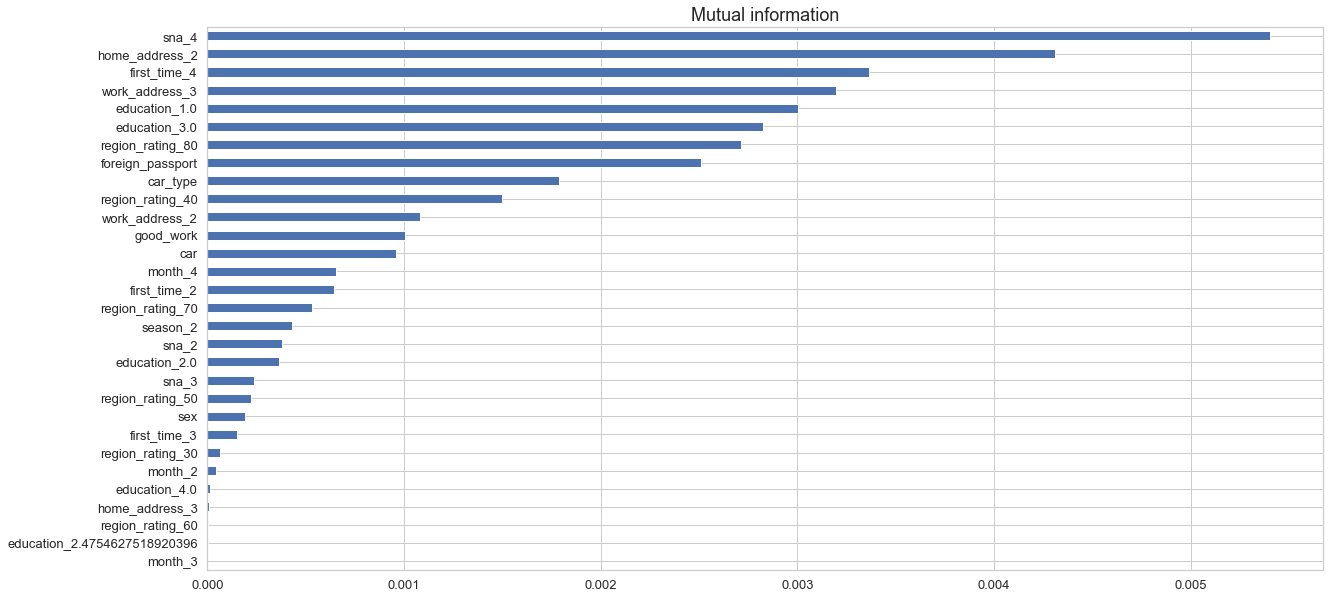

In [41]:
imp_cat = pd.Series(mutual_info_classif(df1[df1['sample'] == 1][bin_cols], df1[df1['sample'] == 1][target],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize=(20, 10))
plt.title('Mutual information', size=18);

Removing features, which does not have sagnificance for modeling

In [42]:
df1.drop(['education_2.4754627518920396', 'month_3', 'region_rating_60'], axis=1, inplace=True)

# Model set

In [43]:
#Deriving training data 
X = df1[df1['sample'] == 1].drop(['default', 'sample'], axis=1).values
y = df1[df1['sample'] == 1][target].values

In [44]:
# Splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Standardizing features
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [45]:
# Model set
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

In [46]:
roc_auc_score(y_val, y_proba[:, 1])

0.7446054654718939

In [47]:
probs = y_proba[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

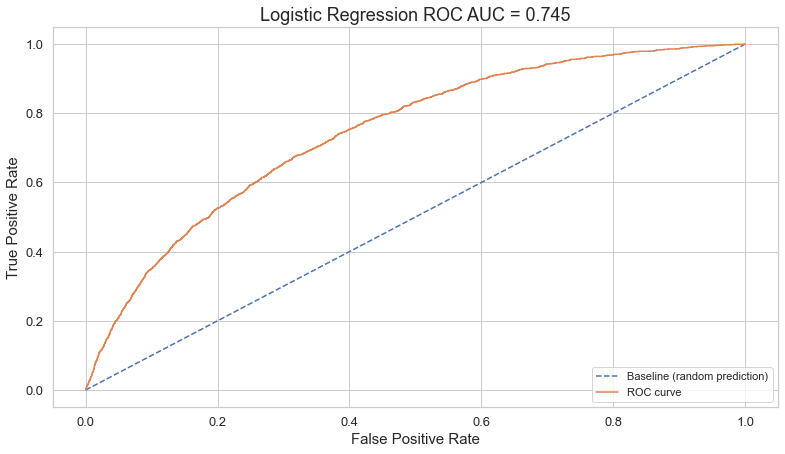

In [48]:
plt.figure()
plt.plot([0, 1], label='Baseline (random prediction)', linestyle='--')
plt.plot(fpr, tpr, label='ROC curve')
plt.title('Logistic Regression ROC AUC = {}'.format(round(roc_auc, 3)), size=18)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show();